In [1]:
%matplotlib inline

import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
from tensorflow.models.rnn import rnn, rnn_cell

from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)



Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [2]:
'''
To classify images using a reccurent neural network, we consider every image row as a sequence of pixels.
Because MNIST image shape is 28*28px, we will then handle 28 sequences of 28 steps for every sample.
'''

# Parameters
learning_rate = 0.0025
training_iters = 5000000
display_step = 50

# Network Parameters
n_input = 28 # MNIST data input (img shape: 28*28)
n_steps = 15 # timesteps
n_hidden = 200 # hidden layer num of features
n_classes = 28 # MNIST total classes (0-9 digits)

batch_size = 150*(27-n_steps)

In [3]:
# tf Graph input
x = tf.placeholder("float", [None, n_steps, n_input])
istate = tf.placeholder("float", [None, 2*n_hidden]) #state & cell => 2x n_hidden
y = tf.placeholder("float", [None, n_classes])

# Define weights
weights = {
    'hidden': tf.Variable(tf.random_normal([n_input, n_hidden])), # Hidden layer weights
    'out': tf.Variable(tf.random_normal([n_hidden, n_classes]))
}
biases = {
    'hidden': tf.Variable(tf.random_normal([n_hidden])),
    'out': tf.Variable(tf.random_normal([n_classes]))
}

In [4]:
def RNN(_X, _istate, _weights, _biases):

    # input shape: (batch_size, n_steps, n_input)
    _X = tf.transpose(_X, [1, 0, 2])  # permute n_steps and batch_size
    # Reshape to prepare input to hidden activation
    _X = tf.reshape(_X, [-1, n_input]) # (n_steps*batch_size, n_input)
    # Linear activation
    _X = tf.matmul(_X, _weights['hidden']) + _biases['hidden']

    # Define a lstm cell with tensorflow
    lstm_cell = rnn_cell.BasicLSTMCell(n_hidden, forget_bias=1.0)
    # Split data because rnn cell needs a list of inputs for the RNN inner loop
    _X = tf.split(0, n_steps, _X) # n_steps * (batch_size, n_hidden)

    # Get lstm cell output
    outputs, states = rnn.rnn(lstm_cell, _X, initial_state=_istate)

    # Linear activation
    # Get inner loop last output
    return tf.nn.sigmoid(tf.matmul(outputs[-1], _weights['out']) + _biases['out'])

In [5]:
pred = RNN(x, istate, weights, biases)

# Define loss and optimizer
cost = tf.reduce_mean(tf.square(pred-y)) # Softmax loss
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost) # Adam Optimizer

In [6]:
def targetFromTrainingData(data, nSteps):
    
    X = []
    Y = []
    
    for sample in data:
        sample = sample.reshape((28,28))
        for i in range(27-nSteps):
            X.append(sample[i:i+nSteps,:])
            Y.append(sample[i+nSteps][:])
    return np.asarray(X), np.asarray(Y)
        


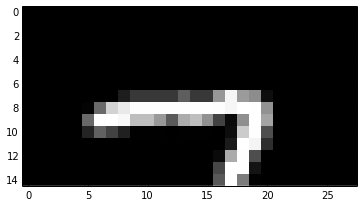

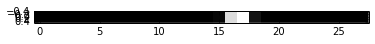

In [17]:
a,b = targetFromTrainingData(mnist.train.next_batch(10)[0], 15)

n = 0

plt.imshow(a[n], cmap="gray", interpolation="none")
plt.show()
plt.imshow(b[n].reshape(1,28),cmap="gray", interpolation="none")

In [18]:
# Initializing the variables
init = tf.initialize_all_variables()

# Launch the graph
sess = tf.Session()
sess.run(init)
step = 1

# Keep training until reach max iterations
while step * batch_size < training_iters:
    batch_xs,_ = mnist.train.next_batch(batch_size/(27-n_steps))
    # Reshape data to get 28 seq of 28 elements
    batch_xs, batch_ys = targetFromTrainingData(batch_xs, n_steps)
    # Fit training using batch data
    sess.run(optimizer, feed_dict={x: batch_xs, y: batch_ys,
                                   istate: np.zeros((batch_size, 2*n_hidden))})
    if step % display_step == 0:
        # Calculate batch loss
        loss = sess.run(cost, feed_dict={x: batch_xs, y: batch_ys,
                                         istate: np.zeros((batch_size, 2*n_hidden))})
        print "Iter " + str(step*batch_size) + ", Minibatch Loss= " + "{:.6f}".format(loss)
    step += 1
print "Optimization Finished!" 

Iter 90000, Minibatch Loss= 0.060781
Iter 180000, Minibatch Loss= 0.038736
Iter 270000, Minibatch Loss= 0.030736
Iter 360000, Minibatch Loss= 0.037417
Iter 450000, Minibatch Loss= 0.031448
Iter 540000, Minibatch Loss= 0.027548
Iter 630000, Minibatch Loss= 0.034440
Iter 720000, Minibatch Loss= 0.025800
Iter 810000, Minibatch Loss= 0.021700
Iter 900000, Minibatch Loss= 0.022563
Iter 990000, Minibatch Loss= 0.020938
Iter 1080000, Minibatch Loss= 0.020958
Iter 1170000, Minibatch Loss= 0.020753
Iter 1260000, Minibatch Loss= 0.020974
Iter 1350000, Minibatch Loss= 0.019289
Iter 1440000, Minibatch Loss= 0.022216
Iter 1530000, Minibatch Loss= 0.019857
Iter 1620000, Minibatch Loss= 0.017079
Iter 1710000, Minibatch Loss= 0.018442
Iter 1800000, Minibatch Loss= 0.021160
Iter 1890000, Minibatch Loss= 0.020281
Iter 1980000, Minibatch Loss= 0.019041
Iter 2070000, Minibatch Loss= 0.018466
Iter 2160000, Minibatch Loss= 0.019285
Iter 2250000, Minibatch Loss= 0.014734
Iter 2340000, Minibatch Loss= 0.01530

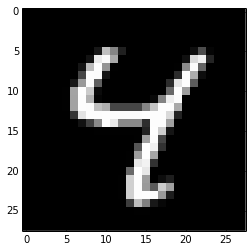

(28, 28)


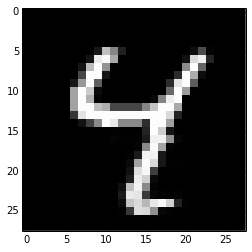

In [25]:
sample = mnist.test.next_batch(1)[0]
seq,_ = targetFromTrainingData(sample,n_steps)

p = sess.run(pred, feed_dict={x: seq,
                          istate: np.zeros((seq.shape[0], 2*n_hidden))} )

sample = sample[0].reshape(28,28)

plt.imshow(sample, interpolation="none", cmap="gray")
plt.show()



sample[16:, :] = p.reshape(-1,28) 
print sample.shape

plt.imshow(sample, interpolation="none", cmap="gray")

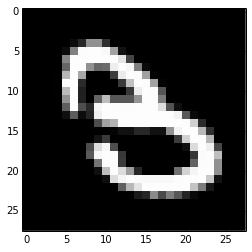

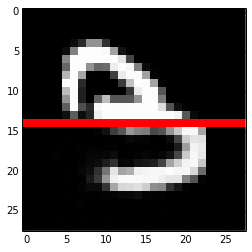

In [37]:
import matplotlib as mpl 

sample = mnist.test.next_batch(1)[0][0].reshape((28,28))
plt.imshow(sample, interpolation="none", cmap="gray")
plt.show()



line = np.zeros((28,28))
line[n_steps, :] = 1
line = np.ma.masked_where(y == 0, y)



for i in range(12):
    
    p = sess.run(pred, feed_dict={x: [sample[i:i+n_steps,:]],
                          istate: np.zeros((1, 2*n_hidden))} )
    sample[i+n_steps] = p

sampleRGB = np.zeros((28,28,3))   

sampleRGB[:,:,0] = sample
sampleRGB[:,:,1] = sample
sampleRGB[:,:,2] = sample

sampleRGB[14,:,:] = 0
sampleRGB[14,:,0] = 1
    
plt.imshow(sampleRGB, interpolation="none")
